# Learn evaluate and compare Classification Models 

* Author: Johannes Maucher
* Last Update: 25.10.2023

In [1]:
#!pip install --upgrade scikit-learn 

In [2]:
%matplotlib inline
import pandas as pd
from IPython.display import display
from IPython.display import Image
import numpy as np
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn import compose
from sklearn.preprocessing import StandardScaler, OneHotEncoder,MinMaxScaler,normalize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, KFold
from sklearn.feature_selection import SelectKBest, mutual_info_regression, f_regression, chi2, f_classif, mutual_info_classif

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import sklearn
sklearn.__version__

'1.3.0'

## Access Data

In this notebook **classification models** are trained and evaluated by the example application **Heart Disease Prediction**. The task is to determine the presence of a heart disease from 13 input features. The applied dataset is available from [http://archive.ics.uci.edu/ml/datasets/Heart+Disease](http://archive.ics.uci.edu/ml/datasets/Heart+Disease). After downloading and storing the corresponding .csv-file it can be accessed using *Pandas*: 

In [6]:
infile="./Data/HeartDiseaseCleveland.csv"
indf=pd.read_csv(infile)
print("Number of rows: ",len(indf))
display(indf.head())

Number of rows:  303


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


**Features:**

1. age: age in years
2. sex: sex (1 = male; 0 = female)
3. cp: chest pain type 
    - Value 1: typical angina 
    - Value 2: atypical angina 
    - Value 3: non-anginal pain 
    - Value 4: asymptomatic 
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital)
6. chol: serum cholestoral in mg/dl
7. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
8. restecg: resting electrocardiographic results 
    - Value 0: normal 
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV) 
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
9. thalach: maximum heart rate achieved
10. exang: exercise induced angina (1 = yes; 0 = no)
11. oldpeak = ST depression induced by exercise relative to rest
12. slope: the slope of the peak exercise ST segment
    - Value 1: upsloping 
    - Value 2: flat 
    - Value 3: downsloping
13. ca: number of major vessels (0-3) colored by flourosopy
14. thal: heartrate
    - Value 3: normal 
    - Value 6: fixed defect
    - Value 7: reversable defect
    
    
**Feature types**
    
- Real-valued attributes: 1,4,5,8,10,12
- Binary attributes: 2,6,9
- Ordered attribute: 11
- Nominal attributes: 3,7,13

**Target (Class label):** 

- 0: no disease
- 1,2,3,4 degree of disease

In this experiment all non-zero classlabels are mapped to 1, i.e. the binary classification just distinguishes disease and no-disease.

## Clean Data
First, we check, if there are missing values in the dataset. In this case the corresponding rows will be deleted.

In [7]:
print(indf.isnull().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [8]:
indf=indf.dropna()
print("Number of rows after deleting rows with missing values: ",len(indf))

Number of rows after deleting rows with missing values:  297


Split features (first 13 columns) from class label (last column):

In [9]:
featureNames=indf.columns[:-1].tolist()
X=indf[featureNames].values
yraw=indf["num"].values
print(X[:4,:])
print(X.shape)

[[ 63.    1.    1.  145.  233.    1.    2.  150.    0.    2.3   3.    0.
    6. ]
 [ 67.    1.    4.  160.  286.    0.    2.  108.    1.    1.5   2.    3.
    3. ]
 [ 67.    1.    4.  120.  229.    0.    2.  129.    1.    2.6   2.    2.
    7. ]
 [ 37.    1.    3.  130.  250.    0.    0.  187.    0.    3.5   3.    0.
    3. ]]
(297, 13)


As described above, in this experiment a binary classifier shall be implemented, which differentiates the classes *disease* and *no disease*. For this all non-zero values in the class-label column are mapped to 1. 

In [10]:
CLIP=True #if True all non-zero classlabels are mapped to 1 (binary classification)
y=np.copy(yraw)
if CLIP:
    y=np.clip(y,a_min=0,a_max=1)
print("Class labels of first 4 samples:   ",y[:4])

Class labels of first 4 samples:    [0 1 1 0]


## One-Hot-Encoding of nominal features
The nominal features in columns 2,6 and 12 must be one-hot-encoded.

```{note} 
The following code-snippet just demonstrates one-hot-encoding in scikit-learn, in particular the arrangement of one-hot encoded nominal features in the transformed feature matrix. Moreover, the function `convert2OneHotFeatureNames()` can be applied to assign the column names to the transformed data.
```

In [11]:
catFeats=[2,6,12]

oheTransformer = compose.make_column_transformer(
    (OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)
Xoh = oheTransformer.fit_transform(X)
print("New shape of feature array:",Xoh.shape)

New shape of feature array: (297, 20)


In [12]:
def convert2OneHotFeatureNames(catFeats,featureNames,X):
    '''
    catFeats:       List, which contains the indices of the nominal features
    featureNames:   List of original featureNames
    X:              2-d Numpy Array containing numerical feature-values before one-hot-encoding
    
    function returns onehotFeatureNames, which are the names of the columns of X after one-hot-encoding
    '''
    nonCatFeatureNames=[f for (i,f) in enumerate(featureNames) if i not in catFeats]
    #print nonCatFeatureNames
    onehotFeatureNames=[]
    for c in catFeats:
        vals=np.unique(X[:,c])
        fname=featureNames[c]
        #print "Values of nominal feature in column %d:  "%(c),vals
        for v in vals:
            onehotFeatureNames.append(fname+"="+str(v))
    onehotFeatureNames.extend(nonCatFeatureNames)
    return onehotFeatureNames
    

The rearrangement of columns becomes obvious if the original feature matrix and the transformed feature matrix are displayed as Pandas dataframes:

In [13]:
featureDF=pd.DataFrame(data=X,columns=featureNames)
print("Feature matrix before One-Hot-Encoding:")
display(featureDF.head())

Feature matrix before One-Hot-Encoding:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [14]:
onehotFeatureNames=convert2OneHotFeatureNames(catFeats,featureNames,X)
oneHotFeatureDF=pd.DataFrame(data=Xoh,columns=onehotFeatureNames)
#oneHotFeatureDF=pd.DataFrame(data=Xoh)
print("Feature matrix after One-Hot-Encoding:")
display(oneHotFeatureDF.head())

Feature matrix after One-Hot-Encoding:


,cp=1.0,cp=2.0,cp=3.0,cp=4.0,restecg=0.0,restecg=1.0,restecg=2.0,thal=3.0,thal=6.0,thal=7.0,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,3.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,2.0,3.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,2.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,3.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,1.0,0.0


Append class label to one-hot-encoded data and write dataframe to .csv-file

In [15]:
oneHotDFall=oneHotFeatureDF
oneHotDFall["num"]=yraw
display(oneHotDFall.head())
oneHotDFall.to_csv("../Data/HeartDiseaseClevelandEncoded.csv")

,cp=1.0,cp=2.0,cp=3.0,cp=4.0,restecg=0.0,restecg=1.0,restecg=2.0,thal=3.0,thal=6.0,thal=7.0,...,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,num
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,145.0,233.0,1.0,150.0,0.0,2.3,3.0,0.0,0
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,1.0,160.0,286.0,0.0,108.0,1.0,1.5,2.0,3.0,2
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,2.0,1
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,130.0,250.0,0.0,187.0,0.0,3.5,3.0,0.0,0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,130.0,204.0,0.0,172.0,0.0,1.4,1.0,0.0,0


```{note} 
Above one-hot-encoding as provided by scikit-learn has been demonstrated. We will apply this function later on, when we build scikit-learn pipelines. The drawback of the scikit-learn function is that it doesn't regard column-names. In order to map the new columns to meaningful names, we implemented our own function `convert2OneHotFeatureNames()`. A better alternative would be the pandas function `get_dummies()`. It provides one-hot-encoding and a corresponding extension of column-names. The use of `get_dummies()` is demonstrated in the code-cell below. However, this pandas-version of One-Hot-Encoding can not be applied within scikit-learn processsing chains, which will be demonstrated below:
```

Alternative: One-Hot-Encoding with [pandas.get_dummies()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html):

In [16]:
indfF=indf.drop(columns="num")
display(indfF.head())
indfFOH=pd.get_dummies(indfF,columns=["cp","restecg","thal"])
display(indfFOH)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


,age,sex,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,cp_1.0,cp_2.0,cp_3.0,cp_4.0,restecg_0.0,restecg_1.0,restecg_2.0,thal_3.0,thal_6.0,thal_7.0
0,63.0,1.0,145.0,233.0,1.0,150.0,0.0,2.3,3.0,0.0,True,False,False,False,False,False,True,False,True,False
1,67.0,1.0,160.0,286.0,0.0,108.0,1.0,1.5,2.0,3.0,False,False,False,True,False,False,True,True,False,False
2,67.0,1.0,120.0,229.0,0.0,129.0,1.0,2.6,2.0,2.0,False,False,False,True,False,False,True,False,False,True
3,37.0,1.0,130.0,250.0,0.0,187.0,0.0,3.5,3.0,0.0,False,False,True,False,True,False,False,True,False,False
4,41.0,0.0,130.0,204.0,0.0,172.0,0.0,1.4,1.0,0.0,False,True,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,140.0,241.0,0.0,123.0,1.0,0.2,2.0,0.0,False,False,False,True,True,False,False,False,False,True
298,45.0,1.0,110.0,264.0,0.0,132.0,0.0,1.2,2.0,0.0,True,False,False,False,True,False,False,False,False,True
299,68.0,1.0,144.0,193.0,1.0,141.0,0.0,3.4,2.0,2.0,False,False,False,True,True,False,False,False,False,True
300,57.0,1.0,130.0,131.0,0.0,115.0,1.0,1.2,2.0,1.0,False,False,False,True,True,False,False,False,False,True


## Training and Test

Simple split in training and test data:

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### Defining the Pipeline
The entire Data Mining process usually comprises a sequence of modules, e.g: 

```data access -> cleaning -> feature selection -> transformations -> modelling -> visualisation -> evaluatio```


In scikit-learn such sequences of modules can comfortably be encapsulated within a single [Pipeline](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn.pipeline.Pipeline). As shown in the code-snippet below, a Pipeline-object can be configured as a sequence of other scikit-learn objects. The restriction is that all but the last module in a pipeline must be of **Transformer**-type. All *Transformers* have a `.fit()`-method for training and a `.transform()`-method to transform data. The last module in the sequence is an **Estimator**-type. All *Estimators* have a `.fit()`-method for training and a `.predict()` method to estimate an output for the given input data. The main benefits of the`**Pipeline**-class are:

* For training the `.fit()`-method must be envoked only once to fit a whole sequence of modules in the pipeline.
* After training the `.predict()`-method must also be envoked only once per pipeline.
* Parameter optimisation, e.g. by Grid-Search can be performed over all parameters in the pipeline. 


In [18]:
catFeats=[2,6,12]
pipe = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), 
                                                            remainder="passthrough")),
                 ('stdSc', StandardScaler(with_mean=True)),
                 #('pca', PCA(n_components=2)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

### Training

In [19]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('oneHot',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  [2, 6, 12])])),
                ('stdSc', StandardScaler()),
                ('clf', LogisticRegression(C=0.1, random_state=1))])

### Evaluation metrics for classifiers
#### The simple way: Accuracy
The accuracy of the classifier in the context of all modules in the pipeline can be calculated by envoking the `.score(X,y)`-function. The function passes data $X$ through all modules of the pipeline. By comparing the outputs of the last module (classifer) to the true labels $y$ the accuracy is calculated. The same result can be obtained by first envoking `y_p=pipe.predict(X,y)` followed by `accuracy_score(y_p,y)` (see below).  

In [20]:
print('Training Accuracy: %.3f' % pipe.score(X_train, y_train)) 
print('Test Accuracy: %.3f' % pipe.score(X_test, y_test)) 

Training Accuracy: 0.855
Test Accuracy: 0.800


#### Confusion Matrix, Precision, Recall, F1-Score
For a more thorough analysis of a classifier, determination of accuracy alone is not sufficient. The metrics defined below provide more subtle information on correct and erroneous events. All of the defined evaluation metrics can be obtained from the confusion matrix. For a binary classifier, the confusion matrix is depicted below. For a *K*-class classifier, the confusion matrix has size $K \times K$. The rows correspond to the true labels, the columns to the predicted labels.

<img src="https://maucher.home.hdm-stuttgart.de/Pics/confusionMat.png" style="width:300px" align="center">

**Accuracy:** The rate of overall correct classifications: 

$$
ACC=\frac{TP+TN}{FP+FN+TP+TN}
$$

**Error Rate:** The rate of overall erroneous classifications: 

$$
ERR=\frac{FP+FN}{FP+FN+TP+TN}
$$

**False Positive Rate:** 

$$
FPR=\frac{FP}{FP+TN}
$$

**True Positive Rate:** 

$$
TPR=\frac{TP}{FN+TP}
$$

**Precision:** How much of the samples, which have been classified as *positive* are actual *positive* 

$$
PRE=\frac{TP}{FP+TP}
$$ 

**Recall:**(=TPR): How much of the true *positive* samples has been classified as *positive* 

$$
REC=\frac{TP}{FN+TP}
$$

**F1-Score:** Harmonic mean of Precision and Recall 

$$
F1=2\frac{PRE \cdot REC }{PRE + REC}
$$

In order to calculate these performance-metrics on the test-data, we first determine the model's prediction on the test-data. Then the corresponding scikit-learn metric-functions are applied as demonstrated below.

In [21]:
y_pred=pipe.predict(X_test)

In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report

The following function just plots the confusion-matrix in a nicer way.

In [23]:
def plot_confusion_matrix(confmat):
    fig, ax = plt.subplots(figsize=(2.5, 2.5))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i,
            s=confmat[i, j],va='center', ha='center')
    plt.xlabel('predicted label')
    plt.ylabel('true label')

[[43  5]
 [13 29]]


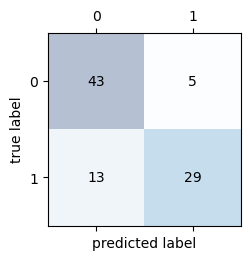

In [24]:
confusion_mat = confusion_matrix(y_test, y_pred)
print(confusion_mat)
plot_confusion_matrix(confusion_mat)

In [25]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred))
print ("Precision:      ",precision_score(y_test, y_pred,average=None))
print ("Recall:         ",recall_score(y_test, y_pred,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred,average=None))

Accuracy:        0.8
Precision:       [0.76785714 0.85294118]
Recall:          [0.89583333 0.69047619]
F1-Score:        [0.82692308 0.76315789]


These metrics can also be calculated in one step, by applying the `classification_report()`-method:

In [26]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83        48
           1       0.85      0.69      0.76        42

    accuracy                           0.80        90
   macro avg       0.81      0.79      0.80        90
weighted avg       0.81      0.80      0.80        90



By comparing the Recall of both classes one can conclude, that this model is better in finding the true *no-disease* cases, than in finding the true *disease*-cases. It would be better in the other way around.

In [27]:
print("Macro averages of precision and recall: \t",(0.77+0.85)/2, (0.9+0.69)/2)
print("Weighted averages of precision and recall: \t",(48*0.77+42*0.85)/90, (48*0.9+42*0.69)/90)

Macro averages of precision and recall: 	 0.81 0.7949999999999999
Weighted averages of precision and recall: 	 0.8073333333333333 0.802


#### Receiver Operating Curves
Receiver Operating Curves (ROC) visualize the performance of a binary classifier as its discrimination threshold is varied.
ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the *ideal* point - a false positive rate of zero, and a true positive rate of one. This is not very realistic. A quantitative performance-measure based on ROC is the Area Under Curve (AUC). The larger the AUC the better the classifier. The maximum value of AUC is 1.

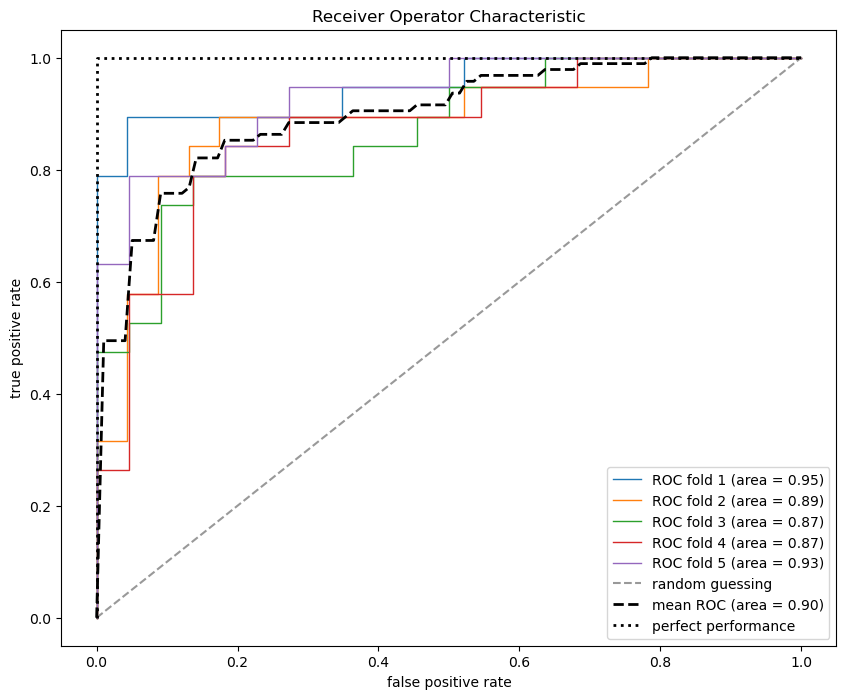

In [28]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
pipe = Pipeline([('scl', StandardScaler()),
                 ('clf', LogisticRegression(penalty='l2',random_state=0,C=100.0))])

splits=5
cv = StratifiedKFold(n_splits=splits)
fig = plt.figure(figsize=(10, 8))
mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []
for i, (train, test) in enumerate(cv.split(X_train,y_train)):
    pipe.fit(X_train[train],y_train[train])
    probas = pipe.predict_proba(X_train[test])    
    fpr, tpr, thresholds = roc_curve(y_train[test],probas[:, 1],pos_label=1)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr,lw=1,label='ROC fold %d (area = %0.2f)'% (i+1, roc_auc))
plt.plot([0, 1],[0, 1],linestyle='--',color=(0.6, 0.6, 0.6),label='random guessing')
mean_tpr /= splits#len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],[0, 1, 1],lw=2,linestyle=':',color='black',label='perfect performance')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc="lower right")
plt.show()

### Cross Validation
Cross-Validation has been described in [section Basic Concepts of Machine Learning](00BasicConcepts.ipynb). The code-cells below demonstrate how crossvalidation can be implemeted with Scikit-Learn. The first option, which applied the `StratifiedKFold()`-class provides more control within the individual iterations of CV. The second option, using `cross_val_score()` is the easier to implement, since only one line of code is required to implement it.

In [29]:
X.shape[0]/10*9

267.3

In [30]:
kfold = StratifiedKFold(n_splits=10)
scores = []
for k, (train, test) in enumerate(kfold.split(X,y)):
    pipe.fit(X[train], y[train])
    score = pipe.score(X[test], y[test])
    scores.append(score)
    print('Fold: %s, Class dist.: %s, Acc: %.3f' % (k+1,np.bincount(y[train]), score))

Fold: 1, Class dist.: [144 123], Acc: 0.867
Fold: 2, Class dist.: [144 123], Acc: 0.867
Fold: 3, Class dist.: [144 123], Acc: 0.767
Fold: 4, Class dist.: [144 123], Acc: 0.967
Fold: 5, Class dist.: [144 123], Acc: 0.800
Fold: 6, Class dist.: [144 123], Acc: 0.767
Fold: 7, Class dist.: [144 123], Acc: 0.767
Fold: 8, Class dist.: [144 124], Acc: 0.897
Fold: 9, Class dist.: [144 124], Acc: 0.724
Fold: 10, Class dist.: [144 124], Acc: 0.862


As can be seen in the example above, the `StratifiedKFold()`-class asserts, that the class-distribution in each cross-validation is the same. 

The same result can be obtained by applying the `cross_val_score`-function:

In [31]:
scores = cross_val_score(estimator=pipe,X=X, y=y,cv=10)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.86666667 0.86666667 0.76666667 0.96666667 0.8        0.76666667
 0.76666667 0.89655172 0.72413793 0.86206897]
CV accuracy: 0.828 +/- 0.071


## Performance without One-Hot-Encoding
Next, we like to find out, if the same linear classification algorithm - `LogisticRegression` - performs better, if One-Hot-Encoding is ignored. For this we remove the One-Hot-Encoder processing from the pipe:

In [32]:
pipe2 = Pipeline([('stdSc', StandardScaler(with_mean=True)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

In [33]:
pipe2.fit(X_train,y_train)

Pipeline(steps=[('stdSc', StandardScaler()),
                ('clf', LogisticRegression(C=0.1, random_state=1))])

In [34]:
y_pred2=pipe2.predict(X_test)

[[44  4]
 [12 30]]


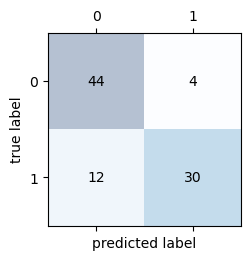

In [35]:
confusion_mat2 = confusion_matrix(y_test, y_pred2)
print(confusion_mat2)
plot_confusion_matrix(confusion_mat2)

In [36]:
print ("Accuracy:       ",accuracy_score(y_test, y_pred2))
print ("Precision:      ",precision_score(y_test, y_pred2,average=None))
print ("Recall:         ",recall_score(y_test, y_pred2,average=None))
print ("F1-Score:       ",f1_score(y_test, y_pred2,average=None))

Accuracy:        0.8222222222222222
Precision:       [0.78571429 0.88235294]
Recall:          [0.91666667 0.71428571]
F1-Score:        [0.84615385 0.78947368]


In [37]:
print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85        48
           1       0.88      0.71      0.79        42

    accuracy                           0.82        90
   macro avg       0.83      0.82      0.82        90
weighted avg       0.83      0.82      0.82        90



Cross Validation

In [38]:
scores = cross_val_score(estimator=pipe2,X=X, y=y,cv=10,n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.86666667 0.83333333 0.76666667 0.96666667 0.8        0.76666667
 0.8        0.86206897 0.75862069 0.86206897]
CV accuracy: 0.828 +/- 0.061


From the comparison of the metrics of the two experiments - with and without One-Hot-Encoding - we conclude:

1. The pipe without One-Hot-Encoding yields a better accuracy
2. Also the most important metric for an application like this, the recall of class disease, is much better without One-Hot-Encoding.

## Explain model by analysing feature importance
Understanding the learned model and it's decision process is crucial for many ML-applications. Methods that provide an understanding of the model are summarised under the term **explainability.**

Binary Linear classifiers learn the parameters $c_i$ of a linear function

$$
c(\mathbf{x})=c_0 + c_1 x_1 + c_2 x_2 + \ldots + c_d x_d, 
$$

where $x_i$ refers to the $i.th$ input-feature.

The learned coefficients $c_i$ indicate the influence of the $i.th$ input-feature on the classification-decision and therefore provide explainability. More concrete:

* the sign of the $i.th$ coefficient determines if the $i.th$ input-feature has a positive or a negative influence on predicting the class, which belongs to the higher index. I.e. if the sign of the $c_i$ is positive, then an increasing value of $x_i$ yields a stronger trend towards the class with index $1$. Correspondingly, if the sign of the $c_i$ is negative, then an increasing value of $x_i$ yields a stronger trend towards the class with index $0$.
* the magnitude of the $i.th$ coefficient, determines how strong the $i.th$ input-feature influences the decision. If the value of $c_i$ is close to 0, then the $i.th$ feature $x_i$ has almost no influence on the classifier's decision.

The learned classifier within the pipe can be accessed by `pipe2.steps[1][1]`. Since this model is an object of class [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html), it's learned coefficients $c_i$ can be accessed by the `coef_`-attribute:

In [39]:
feature_importance= pipe2.steps[1][1].coef_
print(feature_importance)
print(feature_importance.shape)

[[ 0.11726704  0.34678085  0.45483522  0.4162915   0.13773092 -0.13983385
   0.10235511 -0.3609869   0.45228867  0.32454779  0.21666456  0.5236764
   0.53528568]]
(1, 13)


These coefficients are visualized in the cell below:

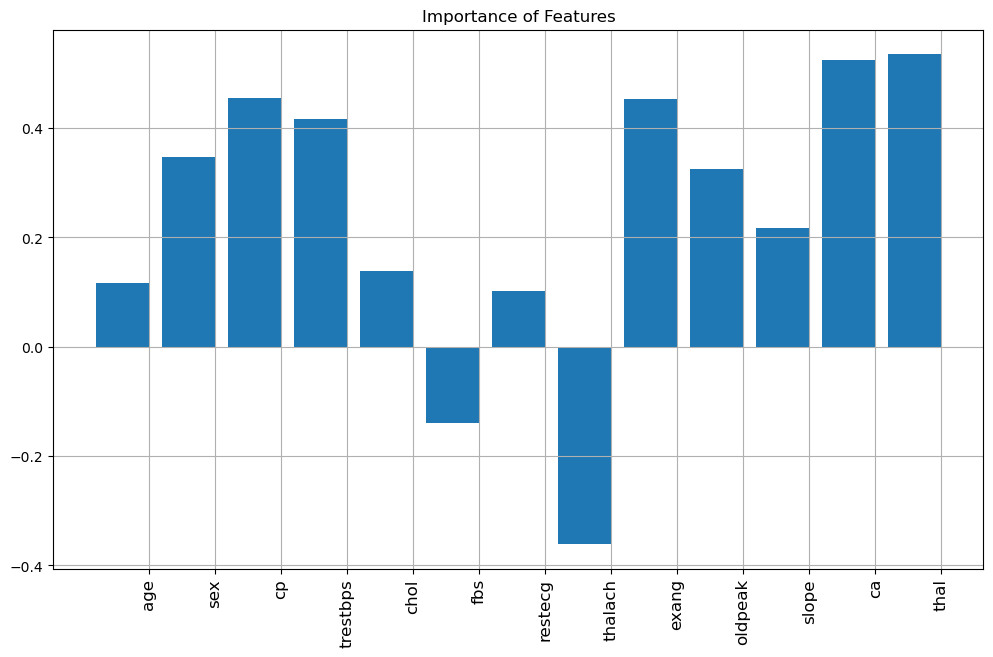

In [40]:
n_feats=len(feature_importance[0])
plt.figure(figsize=(12,7))
plt.bar(range(n_feats),feature_importance[0],)
plt.xticks(np.arange(n_feats)+0.4,featureNames,rotation=90,fontsize=12)
plt.grid(True)
plt.title("Importance of Features")
plt.show()

From this plot we can infer for example: 
* the parameter `thal` (heartrate) has the strongest influence on class `disease`. As defined above `thal=3` indicates a normal heartrate and `thal=6` and `thal=7` refer to pathological heartrates. Since the sign of `thal` is positive: The higher the value, the more likely is class `disease`.
* the parameter `thalach` (maximum achieved heartrate) has the strongest negative impact on `disease`. The higher the maximum achieved heartrate the less likely is class `disease`.

## Multiclass Model
In the previous section we considered the disease-detection problem as a binary-classification task. We have not been interesting in the level of disease, we just wanted to know if the input-features indicate any disease or not. 

However, in the dataset 4 different levels of disease are distinguished. We know won't treat all diseases as one but like to distinguish the different levels. Since we have 4 different diseases and the non-disease case, we now have to implement multiclass-classifier for 5 different classes.

The first 50 class labels:

In [41]:
y=indf["num"].values
print(y[:50])

[0 2 1 0 0 0 3 0 2 1 0 0 2 0 0 0 1 0 0 0 0 0 1 3 4 0 0 0 0 3 0 2 1 0 0 0 3
 1 3 0 4 0 0 0 1 4 0 4 0 0]


Distribution of class labels:

(array([160.,  54.,  35.,  35.,  13.]), array([0., 1., 2., 3., 4., 5.]), <BarContainer object of 5 artists>)


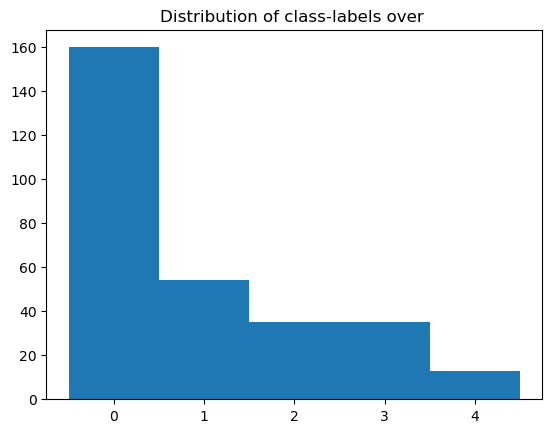

In [42]:
labelhist=plt.hist(y,bins=[0,1,2,3,4,5])
plt.xticks(np.arange(5)+0.5,np.arange(5))
plt.title("Distribution of class-labels over ")
print(labelhist)

The class-distribution, visualized above indicates a severe problem in Machine Learning: We have a relatively low number of labeled data and the number of samples per class strongly varies. This so called **inbalanced data problem** may yield a model, which is strongly *biased* towards the class(es), with much samples (class 0 in this case).

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [44]:
pipe3 = Pipeline([('stdSc', StandardScaler(with_mean=True)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)),
                 #('clf', LogisticRegression(C=0.1,class_weight="balanced",random_state=1)), 
                ])
pipe3.fit(X_train,y_train)
y_pred3=pipe3.predict(X_test)

[[44  3  1  0  0]
 [12  1  1  3  0]
 [ 1  2  2  5  0]
 [ 2  1  5  1  1]
 [ 2  1  2  0  0]]


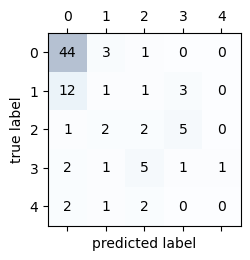

In [45]:
confusion_mat3 = confusion_matrix(y_test, y_pred3)
print(confusion_mat3)
plot_confusion_matrix(confusion_mat3)

In [46]:
print("Accuracy:       ",accuracy_score(y_test, y_pred3))
print("Precision:      ",precision_score(y_test, y_pred3,average=None))
print("Recall:         ",recall_score(y_test, y_pred3,average=None))
print("F1-Score:       ",f1_score(y_test, y_pred3,average=None))

Accuracy:        0.5333333333333333
Precision:       [0.72131148 0.125      0.18181818 0.11111111 0.        ]
Recall:          [0.91666667 0.05882353 0.2        0.1        0.        ]
F1-Score:        [0.80733945 0.08       0.19047619 0.10526316 0.        ]


In [47]:
scores = cross_val_score(estimator=pipe3,X=X, y=y,cv=10,n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.6        0.6        0.56666667 0.66666667 0.53333333 0.53333333
 0.56666667 0.5862069  0.55172414 0.68965517]
CV accuracy: 0.589 +/- 0.050


In [48]:
print(classification_report(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.72      0.92      0.81        48
           1       0.12      0.06      0.08        17
           2       0.18      0.20      0.19        10
           3       0.11      0.10      0.11        10
           4       0.00      0.00      0.00         5

    accuracy                           0.53        90
   macro avg       0.23      0.26      0.24        90
weighted avg       0.44      0.53      0.48        90



The confusion matrix and the classification-metrics show, that we actually ran into the **inbalanced class problem**. Due to the over-presence of class-0-data, most of the test-data is classified to be class 0. Hence the recall in the other classes is quite small.

## Efficient and fast comparison of different processing pipelines

Machine Learning is an empirical science. In order to find a good model for the given task and data one must implement many processing pipelines with different algorithms, hyper-parameters and pre-processing-routines. Each of these configurations must be learned and validated. 

The scikit-learn `Pipeline`-class supports the configuration, training and validation of multiple processing-pipelines and there efficient comparison. This is demonstrated in this subsection. 

For simplicity reasons, in this subsection we again consider the binary-classification problem. I.e

* class-label 0 is clipped to 0
* class-labels 1,2,3,4 are clipped to 1


In [49]:
BINCLASS=True
y=indf["num"].values
if BINCLASS:
    y=np.clip(y,a_min=0,a_max=1)
print("First class labels:  ",y[:8])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

First class labels:   [0 1 1 0 0 0 1 0]


First we define multiple pipelines:

In [50]:
catFeats=[2,6,12]
pipe1 = Pipeline([
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

pipe2 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

pipe3 = Pipeline([('stdSc', StandardScaler(with_mean=True)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])
pipe4 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=True)),
                 #('pca', PCA(n_components=2)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])
pipe5 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=False)),
                 #('pca', PCA(n_components=2)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])
pipe6 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', MinMaxScaler()),
                 #('pca', PCA(n_components=2)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])
pipe7 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=True)),
                 ('featsel',SelectKBest(f_classif,k=8)), 
                 #('pca', PCA(n_components=2)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])
pipe8 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=True)), 
                 ('pca', PCA(n_components=2)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])
pipe9 = Pipeline([('oneHot', compose.make_column_transformer((OneHotEncoder(categories="auto"), catFeats), remainder="passthrough"
)),
                 ('stdSc', StandardScaler(with_mean=True)), 
                 ('lda', LinearDiscriminantAnalysis(n_components=1)),
                 ('clf', LogisticRegression(C=0.1,random_state=1)) 
                ])

In the next cell we apply cross-validation for each of the pipelines defined above:

In [51]:
scores = [
    cross_val_score(mypipe, X, y, scoring='accuracy')
            for mypipe in [pipe1,pipe2,pipe3,pipe4,pipe5,pipe6,pipe7,pipe8,pipe9]
    ]

The code cell below just cares for a more informative output of the accuracy-values of each pipe:

In [52]:
for score,label in zip(scores, 
                       ['only logistic Regression', 
                        'LogReg+OneHotEncoding',
                        'LogReg+Scaling with mean', 
                        'LogReg+OneHot+StdScaling with mean',
                        'LogReg+OneHot+StdScaling without mean',
                        'LogReg+OneHot+MinmaxScaling',
                        'LogReg+OneHot+StdScaling with mean + select k best',
                        'LogReg+OneHot+StdScaling with mean + PCA',
                        'LogReg+OneHot+StdScaling with mean + LDA',
                        ]
                       ):
    print("Accuracy: {:.2%} (+/- {:.2%}), {:}".format(score.mean(), score.std(), label))

Accuracy: 83.15% (+/- 2.50%), only logistic Regression
Accuracy: 84.84% (+/- 3.41%), LogReg+OneHotEncoding
Accuracy: 82.81% (+/- 3.01%), LogReg+Scaling with mean
Accuracy: 82.82% (+/- 4.48%), LogReg+OneHot+StdScaling with mean
Accuracy: 82.82% (+/- 4.48%), LogReg+OneHot+StdScaling without mean
Accuracy: 82.47% (+/- 3.01%), LogReg+OneHot+MinmaxScaling
Accuracy: 84.14% (+/- 4.69%), LogReg+OneHot+StdScaling with mean + select k best
Accuracy: 84.17% (+/- 3.46%), LogReg+OneHot+StdScaling with mean + PCA
Accuracy: 83.15% (+/- 4.91%), LogReg+OneHot+StdScaling with mean + LDA


Among the implemented processing chains, the one with one-hot-encoding and logistic regression performs best.

### Parameterized Pipelines
As shown in the next cell, pipeline-objects can also be parameterized. Here, Multi-Layer-Perceptrons with different numbers of hidden layers and different numbers of neurons per hidden-layer are compared.

In [53]:
pipelist=[]
hiddenConfs=[(10,),(30,),(50,),(100,),(10,10),(30,30),(50,50),(100,50),(100,100),(200,100),(200,200)]
for idx,hid in enumerate(hiddenConfs):
    pipe=Pipeline([
                    ("mlp_"+str(idx),MLPClassifier(hidden_layer_sizes=hid,max_iter=1000))
                  ])
    pipelist.append(pipe)

In [54]:
scores = [ cross_val_score(reg,X,y,scoring='accuracy') for reg in pipelist ]

In [55]:
for score,label in zip(scores,hiddenConfs):
    print("Accuracy: %5.2f (+/- %5.2f) \t for network %s "%(score.mean(), score.std(), label))

Accuracy:  0.66 (+/-  0.17) 	 for network (10,) 
Accuracy:  0.80 (+/-  0.03) 	 for network (30,) 
Accuracy:  0.74 (+/-  0.07) 	 for network (50,) 
Accuracy:  0.79 (+/-  0.03) 	 for network (100,) 
Accuracy:  0.80 (+/-  0.03) 	 for network (10, 10) 
Accuracy:  0.80 (+/-  0.02) 	 for network (30, 30) 
Accuracy:  0.77 (+/-  0.02) 	 for network (50, 50) 
Accuracy:  0.76 (+/-  0.05) 	 for network (100, 50) 
Accuracy:  0.75 (+/-  0.03) 	 for network (100, 100) 
Accuracy:  0.77 (+/-  0.04) 	 for network (200, 100) 
Accuracy:  0.73 (+/-  0.10) 	 for network (200, 200) 


None of the pipelines above, integrates scaling. However, scaling of input-features is crucial for neural networks. The next pipeline-list contains the same pipelines as above, but now with *MinMax-Scaling*.
As can be seen, the accuracy-values are much better now:

In [56]:
pipelist=[]
hiddenConfs=[(10,),(30,),(50,),(100,),(10,10),(30,30),(50,50),(100,50),(100,100),(200,100),(200,200)]
for idx,hid in enumerate(hiddenConfs):
    pipe=Pipeline([('stdSc', MinMaxScaler()),
                    ("mlp_"+str(idx),MLPClassifier(hidden_layer_sizes=hid,max_iter=1000))
                  ])
    pipelist.append(pipe)

In [57]:
scores = [ cross_val_score(reg,X,y,scoring='accuracy') for reg in pipelist ]

In [58]:
for score,label in zip(scores,hiddenConfs):
    print("Accuracy: %5.2f (+/- %5.2f) \t for network %s "%(score.mean(), score.std(), label))

Accuracy:  0.82 (+/-  0.02) 	 for network (10,) 
Accuracy:  0.82 (+/-  0.04) 	 for network (30,) 
Accuracy:  0.82 (+/-  0.04) 	 for network (50,) 
Accuracy:  0.82 (+/-  0.04) 	 for network (100,) 
Accuracy:  0.79 (+/-  0.03) 	 for network (10, 10) 
Accuracy:  0.80 (+/-  0.05) 	 for network (30, 30) 
Accuracy:  0.79 (+/-  0.04) 	 for network (50, 50) 
Accuracy:  0.78 (+/-  0.04) 	 for network (100, 50) 
Accuracy:  0.79 (+/-  0.03) 	 for network (100, 100) 
Accuracy:  0.81 (+/-  0.03) 	 for network (200, 100) 
Accuracy:  0.79 (+/-  0.03) 	 for network (200, 200) 
